In [1]:
from states import Plan_schema, File_schema, ImplementationTask, TaskPlan_schema
from tools import get_current_directory, file_management_tools, run_cmd
from prompts import PLANNER_PROMPT, ARCHITECT_PROMPT, CODER_SYSTEM_PROMPT

from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Optional
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
llm1 = ChatGroq(model="llama-3.1-8b-instant")
llm2 = ChatGroq(model="openai/gpt-oss-120b")

In [3]:
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    user_prompt: str

    # Output of planner agent
    plan_name: str
    plan_description: str
    plan_techstack: str
    plan_features: str
    plan_files: str

    # output of architect agent
    implementation_steps: List[ImplementationTask]

    # output of coder agent
    messages: List[BaseMessage]
    current_step_index: int

## **Defining Nodes**


In [4]:
# planner agent node
def planner_agent(state: AgentState) -> AgentState:
    """Converts user prompt into a structured Plan."""
    user_prompt = state["user_prompt"]

    planner_agent_prompt = ChatPromptTemplate.from_messages([
        ("system", PLANNER_PROMPT),
        ("user", f"user request: {user_prompt}")
    ])

    llm_with_schema = llm1.with_structured_output(Plan_schema)

    chain = planner_agent_prompt | llm_with_schema

    response = chain.invoke({"user_prompt": user_prompt})

    state["plan_name"] = response.name
    state["plan_description"] = response.description
    state["plan_techstack"] = response.techstack
    state["plan_features"] = response.features
    state["plan_files"] = response.files

    return state

## Testing planner node


In [5]:
# user_prompt = "build calculator app in python with a GUI that can perform basic arithmetic operations and has a history feature."

# planner_agent_prompt = ChatPromptTemplate.from_messages([
#     ("system", PLANNER_PROMPT),
#     ("user", f"user request: {user_prompt}")
# ])

# llm_with_schema = llm1.with_structured_output(Plan_schema)

# chain = planner_agent_prompt | llm_with_schema

# response = chain.invoke({"user_prompt": user_prompt})

# print("Plan Name=", response.name)
# print("Plan Description=", response.description)
# print("Plan Techstack=", response.techstack)
# print("Plan Features=", response.features)
# print("Plan Files=", response.files)

In [6]:
# architect agent node
def architect_agent(state: AgentState) -> AgentState:
    """Creates detailed implementation tasks for each file in the plan."""

    project_name = state["plan_name"]
    plan_description = state["plan_description"]
    plan_features = state["plan_features"]
    plan_files = state["plan_files"]

    architect_agent_prompt = ChatPromptTemplate.from_messages([
        ("system", ARCHITECT_PROMPT),
        ("user", f"""
        Project Name: {project_name}
        Plan Description: {plan_description}
        Features: {plan_features}
        Files: {plan_files}
        """)
    ])

    llm_with_schema = llm2.with_structured_output(TaskPlan_schema)

    chain = architect_agent_prompt | llm_with_schema

    response = chain.invoke({
        "plan_name": project_name,
        "plan_description": plan_description,
        "plan_features": plan_features,
        "plan_files": plan_files
    })

    state["implementation_steps"] = response.implementation_steps
    return state

## Testing architect node


In [7]:
# project_name = response.name
# plan_description = response.description
# plan_features = response.features
# plan_files = response.files

# architect_agent_prompt = ChatPromptTemplate.from_messages([
#     ("system", ARCHITECT_PROMPT),
#     ("user", f"""
#         Project Name: {project_name}
#         Plan Description: {plan_description}
#         Features: {plan_features}
#         Files: {plan_files}
#         """)
# ])

# llm_with_schema = llm2.with_structured_output(TaskPlan_schema)

# chain = architect_agent_prompt | llm_with_schema

# response = chain.invoke({
#     "plan_name": project_name,
#     "plan_description": plan_description,
#     "plan_features": plan_features,
#     "plan_files": plan_files
# })

In [8]:
# print(f"Implementation Steps = {response.implementation_steps}")

# steps_for_coder = response.implementation_steps

# **Coder Agent Node**


### **Tools for Coder Agent**


In [9]:
tools_coder_agent = [get_current_directory, *file_management_tools, run_cmd]

llm_with_tools = llm2.bind_tools(tools_coder_agent)

tools_coder_agent

[StructuredTool(name='get_current_directory', description='Returns the current working directory.', args_schema=<class 'langchain_core.utils.pydantic.get_current_directory'>, func=<function get_current_directory at 0x0000022CB23D4220>),
 CopyFileTool(root_dir='c:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\Software_Builder_Agent\\src'),
 DeleteFileTool(root_dir='c:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\Software_Builder_Agent\\src'),
 FileSearchTool(root_dir='c:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\Software_Builder_Agent\\src'),
 MoveFileTool(root_dir='c:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\Software_Builder_Agent\\src'),
 ReadFileTool(root_dir='c:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\Software_Builder_Agent\\src'),
 WriteFileTool(root_dir='c:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\Software_Builder_Agent\\src'),
 ListDirectoryTool(root_dir='c:\\Users\\yasho\\OneDrive\\Desktop\\LANGGRAPH_TUT\\Software_Builder_Agent\\src'),
 Str

In [10]:
def coder_agent(state: AgentState) -> AgentState:
    """Implements each file using tools."""

    steps = state["implementation_steps"]
    current_index = state.get("current_step_index", 0)

    # If we've completed all steps, return with empty messages to signal END
    if current_index >= len(steps):
        state["messages"] = []
        return state

    # Get the current step
    step = steps[current_index]

    coder_prompt = ChatPromptTemplate.from_messages([
        ("system", CODER_SYSTEM_PROMPT),
        ("user", f"""
        Implement this task:

        Filepath: {step.filepath}
        Task Description: {step.task_description}

        Use file tools to create or update the file.
        """)
    ])

    chain = coder_prompt | llm_with_tools

    response = chain.invoke({})

    print(f"Processing step {current_index + 1}/{len(steps)}: {step.filepath}")

    # Store the response message and increment step index
    state["messages"] = [response]
    state["current_step_index"] = current_index + 1

    return state

## **Building Graph**


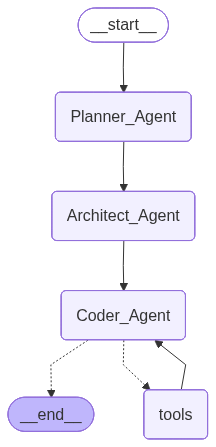

In [11]:
from langgraph.prebuilt import tools_condition, ToolNode


def route_coder(state: AgentState):
    """Route from coder agent to either tools or END."""
    # Check if all steps are completed
    current_index = state.get("current_step_index", 0)
    total_steps = len(state.get("implementation_steps", []))

    if current_index >= total_steps:
        return END

    # Check if there are tool calls in the last message
    messages = state.get("messages", [])
    if messages and hasattr(messages[-1], "tool_calls") and len(messages[-1].tool_calls) > 0:
        return "tools"

    return END


graph = StateGraph(AgentState)

graph.add_node("Planner_Agent", planner_agent)
graph.add_node("Architect_Agent", architect_agent)
graph.add_node("Coder_Agent", coder_agent)

# tool node
tools = ToolNode(tools=tools_coder_agent)
graph.add_node("tools", tools)

graph.add_edge(START, "Planner_Agent")
graph.add_edge("Planner_Agent", "Architect_Agent")
graph.add_edge("Architect_Agent", "Coder_Agent")

graph.add_conditional_edges("Coder_Agent", route_coder, {
                            "tools": "tools", END: END})
graph.add_edge("tools", "Coder_Agent")

app = graph.compile()
app

In [12]:
response = app.invoke({
    "user_prompt": "build calculator app in python with a GUI that can perform basic arithmetic operations and has a history feature. in the separate folder as 'project_1'",
    "plan_name": "",
    "plan_description": "",
    "plan_techstack": "str",
    "plan_features": "str",
    "plan_files": "str",
    "implementation_steps": [],
    "messages": [],
    "current_step_index": 0
})

Processing step 1/2: project_1/tests/test_calc.py
Processing step 2/2: project_1/tests/test_gui.py


In [13]:
response

{'user_prompt': "build calculator app in python with a GUI that can perform basic arithmetic operations and has a history feature. in the separate folder as 'project_1'",
 'plan_name': 'Calculator App',
 'plan_description': 'A simple graphical user interface (GUI) calculator application with basic arithmetic operations and a history feature',
 'plan_techstack': 'python',
 'plan_features': ['user authentication',
  'form handling',
  'routing',
  'paging',
  'history feature',
  'basic arithmetic operations'],
 'plan_files': [File_schema(path='project_1/tests/test_calc.py', purpose='unit tests for calc.py'),
  File_schema(path='project_1/tests/test_gui.py', purpose='unit tests for gui.py')],
 'implementation_steps': [ImplementationTask(filepath='project_1/tests/test_calc.py', task_description="Create the unit test module for the calculator logic. The file should import the `Calculator` class from `project_1/calc.py`. Using `pytest`, write a series of test functions that cover all basic 